# Importing Libraries

In [23]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

In [24]:
import classes.file_loader as file_loader
import classes.linear_time_series as linear_time_series
import classes.tools as tools
import classes.gated_reccurent_unit as gated_reccurent_unit
import classes.long_short_term_memory as long_short_term_memory

# Data Preprocessing

## Loading Files

In [25]:
file_path = "" # File is in the parent file
file_name = "Index.xlsx"

FileLoader = file_loader.FileLoader(file_path, file_name)

In [26]:
warnings.filterwarnings("ignore")

classic_sheet_name, precarity_sheet_name = "Classique","Précarité"

classic_raw_df, preacarity_raw_df = FileLoader.load_file(classic_sheet_name, precarity_sheet_name)

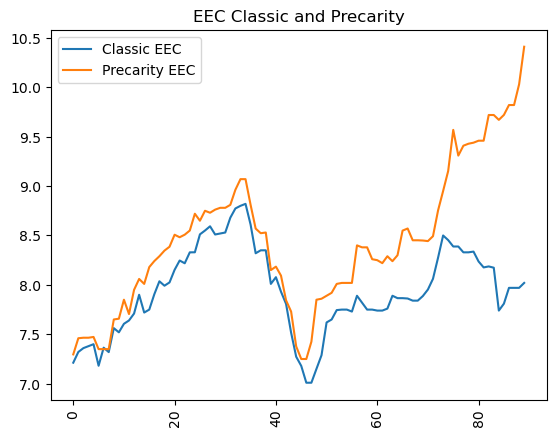

In [27]:
plt.figure()

plt.plot(classic_raw_df["SPOT"], label = "Classic EEC")
plt.plot(preacarity_raw_df["SPOT"], label = "Precarity EEC")
plt.title("EEC Classic and Precarity")
plt.legend()
plt.xticks(rotation = 90)

plt.show()

In [28]:
classic_raw_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-05-01,7.321166
2,2023-05-08,7.360211
3,2023-05-15,7.380000
4,2023-05-22,7.400000
...,...,...
85,2024-12-16,7.810000
86,2024-12-23,7.970000
87,2024-12-30,7.970000
88,2025-01-06,7.970000


In [29]:
preacarity_raw_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-05-01,7.460184
2,2023-05-08,7.465385
3,2023-05-15,7.465385
4,2023-05-22,7.473191
...,...,...
85,2024-12-16,9.720000
86,2024-12-23,9.820000
87,2024-12-30,9.820000
88,2025-01-06,10.030000


## Augmented dataframes

In [30]:
augmented_classic_df = FileLoader.interpolate_dataframe(classic_raw_df)
augmented_classic_df.to_csv("augmented_classic_df.csv", index=False)
augmented_classic_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-04-25,7.199835
2,2023-04-26,7.239017
3,2023-04-27,7.201446
4,2023-04-28,7.272471
...,...,...
446,2025-01-07,7.989051
447,2025-01-08,7.999844
448,2025-01-09,7.984841
449,2025-01-10,8.010518


In [31]:
augmented_precarity_df = FileLoader.interpolate_dataframe(preacarity_raw_df)
augmented_precarity_df.to_csv("augmented_precarity_df.csv", index=False)
augmented_precarity_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-04-25,7.325606
2,2023-04-26,7.315121
3,2023-04-27,7.384773
4,2023-04-28,7.412007
...,...,...
446,2025-01-07,10.088537
447,2025-01-08,10.069693
448,2025-01-09,10.219854
449,2025-01-10,10.236960


## Plotting the selected augmented dataframes 

We select one iteration of fir the classic and precarirty dataframe.

In [32]:
classic_df = pd.read_csv("selected_augmented_classic_df.csv")
precarity_df = pd.read_csv("selected_augmented_precarity_df.csv")

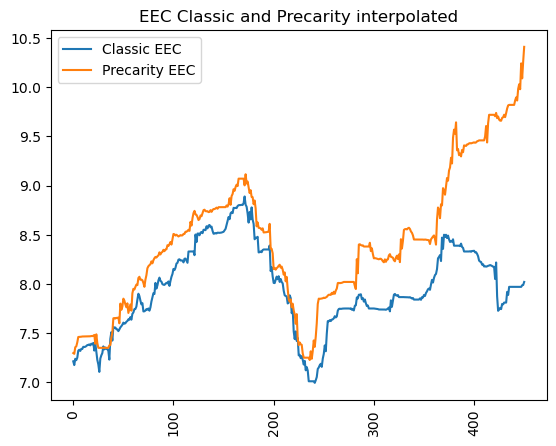

In [33]:
plt.figure()

plt.plot(classic_df["SPOT"], label = "Classic EEC")
plt.plot(precarity_df["SPOT"], label = "Precarity EEC")
plt.title("EEC Classic and Precarity interpolated")
plt.legend()
plt.xticks(rotation = 90)

plt.show()

Now we will separate data between data that will be used to train our models and the data which will be used to test our trading strategies.

From the graph we can clearly see that the data is non stationnary. We will first differentiate the time series and check weither it has 

In [34]:
classic_df["Delta"] = classic_df["SPOT"] - classic_df["SPOT"].shift(1)
classic_df.dropna(inplace = True)
classic_df

,Date,SPOT,Delta
1,2023-04-25,7.174503,-0.038213
2,2023-04-26,7.238924,0.064421
3,2023-04-27,7.224501,-0.014423
4,2023-04-28,7.249729,0.025228
5,2023-05-01,7.321166,0.071437
...,...,...,...
446,2025-01-07,7.969759,-0.000241
447,2025-01-08,7.969839,0.000079
448,2025-01-09,7.986663,0.016825
449,2025-01-10,7.988577,0.001914


Neural Networks do not necessarily need stationnary data. However they perform better on normalized data. Hence we create the normalized data using Min-Max Scaler as the data is not normally distributed :

In [35]:
minmax_scaler = MinMaxScaler()
classic_df["Normalized Spot"] = minmax_scaler.fit_transform(classic_df[["SPOT"]])
classic_df

,Date,SPOT,Delta,Normalized Spot
1,2023-04-25,7.174503,-0.038213,0.095268
2,2023-04-26,7.238924,0.064421,0.129266
3,2023-04-27,7.224501,-0.014423,0.121654
4,2023-04-28,7.249729,0.025228,0.134968
5,2023-05-01,7.321166,0.071437,0.172669
...,...,...,...,...
446,2025-01-07,7.969759,-0.000241,0.514964
447,2025-01-08,7.969839,0.000079,0.515006
448,2025-01-09,7.986663,0.016825,0.523885
449,2025-01-10,7.988577,0.001914,0.524895


In [36]:
classic_development_df, classic_test_df = classic_df[:int(0.80*len(classic_df))], classic_df[int(0.80*len(classic_df)):]

In [37]:
classic_development_df

,Date,SPOT,Delta,Normalized Spot
1,2023-04-25,7.174503,-0.038213,0.095268
2,2023-04-26,7.238924,0.064421,0.129266
3,2023-04-27,7.224501,-0.014423,0.121654
4,2023-04-28,7.249729,0.025228,0.134968
5,2023-05-01,7.321166,0.071437,0.172669
...,...,...,...,...
356,2024-09-03,7.939913,-0.013183,0.499213
357,2024-09-04,7.993982,0.054069,0.527747
358,2024-09-05,8.041032,0.047050,0.552578
359,2024-09-06,8.013912,-0.027120,0.538266


In [38]:
classic_test_df

,Date,SPOT,Delta,Normalized Spot
361,2024-09-10,8.089756,0.028217,0.578292
362,2024-09-11,8.101701,0.011945,0.584596
363,2024-09-12,8.149817,0.048116,0.609989
364,2024-09-13,8.259876,0.110059,0.668073
365,2024-09-16,8.274618,0.014742,0.675853
...,...,...,...,...
446,2025-01-07,7.969759,-0.000241,0.514964
447,2025-01-08,7.969839,0.000079,0.515006
448,2025-01-09,7.986663,0.016825,0.523885
449,2025-01-10,7.988577,0.001914,0.524895


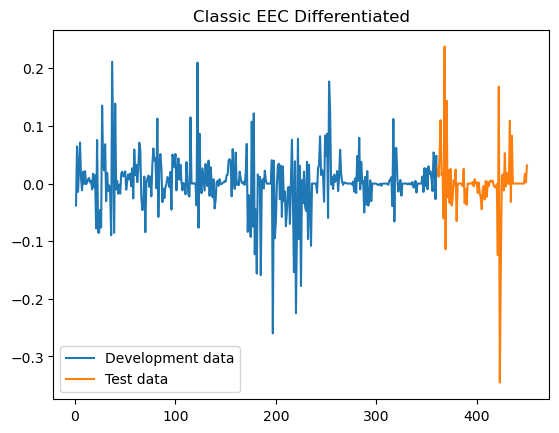

In [39]:
plt.figure()
plt.plot(classic_development_df["Delta"], label="Development data")
plt.plot(classic_test_df["Delta"], label="Test data")
plt.title("Classic EEC Differentiated")
plt.legend()
plt.show()

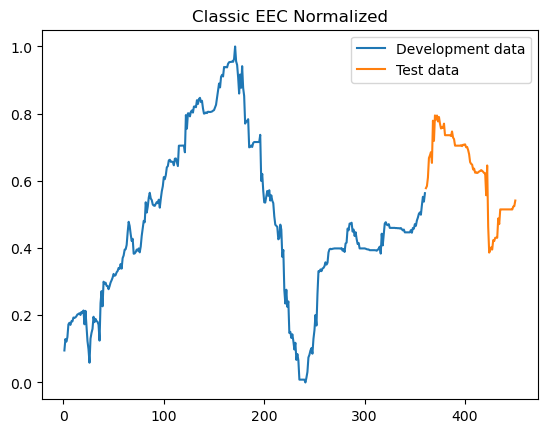

In [40]:
plt.figure()
plt.plot(classic_development_df["Normalized Spot"], label="Development data")
plt.plot(classic_test_df["Normalized Spot"], label="Test data")
plt.title("Classic EEC Normalized")
plt.legend()
plt.show()

# Data forecasting

## Classic EEC

### ARMA

We create an ARMA model (in reality ARIMA as the series was already differentiated), using a class built on our own.

In [41]:
result = adfuller(classic_development_df["Delta"], regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_values, icbest = result

print(f"p-value: {pvalue}")

if pvalue < 0.05:
    print("Result: reject unit root -> series is stationary (at 5% level).")
else:
    print("Result: fail to reject unit root -> series is non-stationary.")

p-value: 8.410526298029595e-14
Result: reject unit root -> series is stationary (at 5% level).


In [42]:
# Initiate the ARMA class

LinearTimeSeriesModel = linear_time_series.LinearTimeSeriesModel(classic_development_df["Delta"])

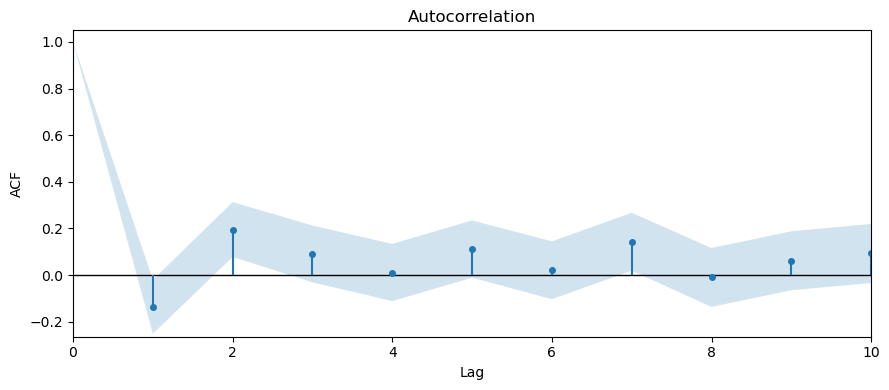

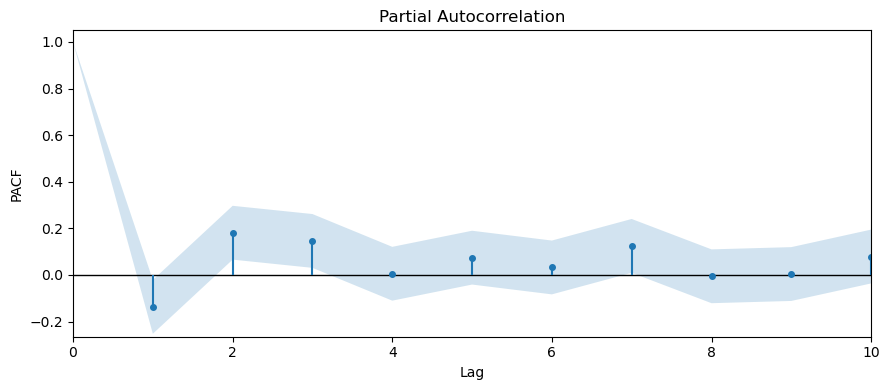

Max MA order: 2, Max AR order: 3


In [43]:
# Selecting the last relevant lags

LinearTimeSeriesModel.get_ma_max_order(plot=True)
LinearTimeSeriesModel.get_ar_max_order(plot=True)
print(f"Max MA order: {LinearTimeSeriesModel.ma_max_order}, Max AR order: {LinearTimeSeriesModel.ar_max_order}")

In [44]:
# Selecting the best model according to AIC using the maximum relevant lags

selected_models = LinearTimeSeriesModel.select_model()
selected_models["aicc"]

The p-value of the L-JungBox test is 0.0010769501074859085 for the model ARIMA(0,0,0) with AIC = -865.2753020188438
The p-value of the L-JungBox test is 0.00019603097391517166 for the model ARIMA(1,0,0) with AIC = -868.69992441343
The p-value of the L-JungBox test is 0.16297763067651264 for the model ARIMA(2,0,0) with AIC = -876.2575485804443
The p-value of the L-JungBox test is 0.7157039278648097 for the model ARIMA(3,0,0) with AIC = -880.2907981667475
The p-value of the L-JungBox test is 0.00035552134321538046 for the model ARIMA(0,0,1) with AIC = -867.1486027223268
The p-value of the L-JungBox test is 0.0009961180754488983 for the model ARIMA(1,0,1) with AIC = -869.6690742834805
The p-value of the L-JungBox test is 0.9172372269960318 for the model ARIMA(2,0,1) with AIC = -883.1324185445949
The p-value of the L-JungBox test is 0.9437340891958436 for the model ARIMA(3,0,1) with AIC = -881.5936067228174
The p-value of the L-JungBox test is 0.28029800966799606 for the model ARIMA(0,0,2)

{'order': (2, 0, 1), 'aicc': -882.9196525871481}

In [45]:
# Prediction using our model
train_pred, validation_pred = LinearTimeSeriesModel.model_prediction()

# Cumulative sum to get back to the original scale
cum_train_pred = np.cumsum(train_pred) + classic_development_df["SPOT"].iloc[0]
cum_train_real = np.cumsum(LinearTimeSeriesModel.train_dependent) + classic_development_df["SPOT"].iloc[0]

cum_validation_pred = np.cumsum(validation_pred) + cum_train_pred.iloc[-1]
cum_validation_real = np.cumsum(LinearTimeSeriesModel.validation_dependent) + classic_development_df["SPOT"].iloc[0]

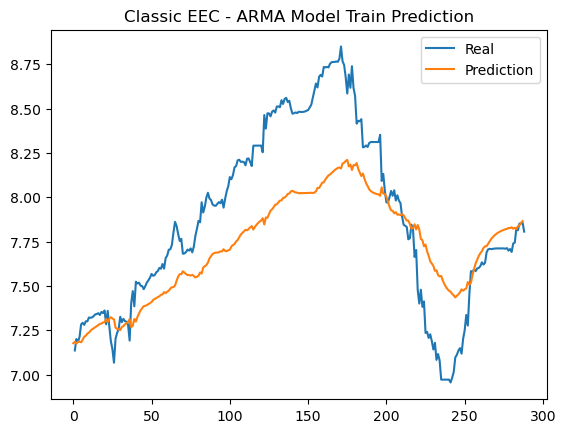

In [46]:
plt.figure()
plt.title("Classic EEC - ARMA Model Train Prediction")
plt.plot(cum_train_real, label="Real")
plt.plot(cum_train_pred, label="Prediction")
plt.legend()
plt.show()

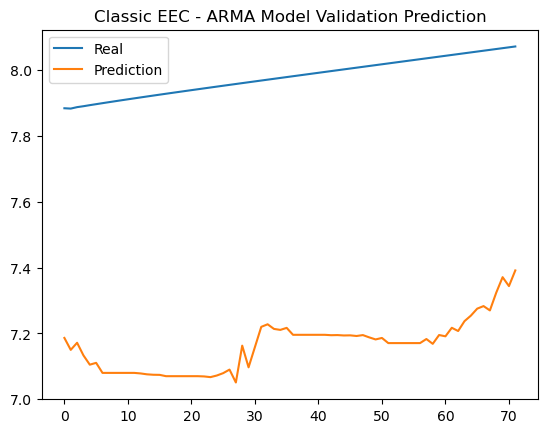

In [47]:
plt.figure()
plt.title("Classic EEC - ARMA Model Validation Prediction")
plt.plot(cum_validation_pred.reset_index(drop=True), label="Real")
plt.plot(cum_validation_real, label="Prediction")
plt.legend()
plt.show()

In [48]:
# Asssessing performances of ARIMA model
arima_model_metrics = tools.model_metrics(cum_train_real, cum_train_pred, cum_validation_real, cum_validation_pred)

all_metrics = arima_model_metrics.get_all_metrics()

print(all_metrics["train"])

print(all_metrics["validation"])

{'mae': 0.2730466389385462, 'rmse': 0.3385583106514087, 'mse': 0.11462172971113574, 'mape': 3.4013534814716833, 'r2': 0.5606640317756916}
{'mae': nan, 'rmse': 0.8169689412986304, 'mse': 0.667438251046605, 'mape': nan, 'r2': 1.0}


### RNN

Parameters to optimize :

-   Lookback : Number of points used to predict the next oneNombre de points utilisés pour prédire le point suivant
-   Hidden size : Number of GRU cells per layer
-   Number of layers : Number of layers

#### Gated Reccurent Unit (GRU)

In [49]:
# Initializing the GRU class
GRU = gated_reccurent_unit.GRU(classic_development_df["Normalized Spot"], train_test_ratio=0.8)

##### Tuning Training Parameters

In [50]:
train_param_grid = {
    "l2" : [1e-02, 1e-03, 1e-04, 1e-05, 1e-06],
    "lrs" : [1, 0.1, 0.01, 0.001],
    "epochs" : [20, 30, 40, 60, 80, 100, 120, 140],
    "epochs_mid" : 80,
    "patience": 10,
    "min_delta": 1e-4,
    "n_splits": 5,
    "val_size": 200,
    "min_train_size" : 50     
}

model_param = {
    "lookback": 40,
    "hidden_size": 16,
    "num_layers": 1,
}
GRU_training_aprams = GRU.tune_train(train_param_grid, model_param)

GRU.training_params

Training results: cv_mse : 0.04980762302875519, val_size : 200, n_splits : 5


{'lr': 0.1, 'l2': 1e-05, 'epochs': 140}

##### Tuning Model Parameters

In [51]:
model_param_grid = {
    "lookback": [int(x) for x in np.linspace(10, 70, 6)],
    "hidden_size": [2, 4, 8, 16],
    "num_layers": [1, 2],
}
GRU.tune_model(model_param_grid)

lookback=10, hidden=2, layers=1 → MSE=0.000182
lookback=10, hidden=2, layers=2 → MSE=0.000241
lookback=10, hidden=4, layers=1 → MSE=0.000170
lookback=10, hidden=4, layers=2 → MSE=0.000182
lookback=10, hidden=8, layers=1 → MSE=0.000164
lookback=10, hidden=8, layers=2 → MSE=0.000172
lookback=10, hidden=16, layers=1 → MSE=0.000164
lookback=10, hidden=16, layers=2 → MSE=0.000191
lookback=22, hidden=2, layers=1 → MSE=0.000191
lookback=22, hidden=2, layers=2 → MSE=0.000228
lookback=22, hidden=4, layers=1 → MSE=0.000163
lookback=22, hidden=4, layers=2 → MSE=0.000192
lookback=22, hidden=8, layers=1 → MSE=0.000157
lookback=22, hidden=8, layers=2 → MSE=0.000447
lookback=22, hidden=16, layers=1 → MSE=0.000155
lookback=22, hidden=16, layers=2 → MSE=0.000216
lookback=34, hidden=2, layers=1 → MSE=0.000170
lookback=34, hidden=2, layers=2 → MSE=0.000179
lookback=34, hidden=4, layers=1 → MSE=0.000176
lookback=34, hidden=4, layers=2 → MSE=0.000183
lookback=34, hidden=8, layers=1 → MSE=0.000161
lookback=

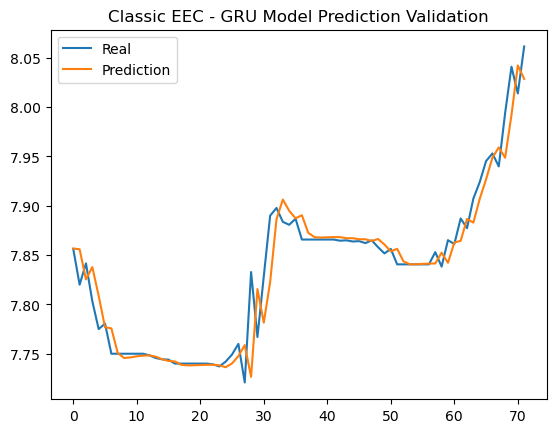

In [52]:
data_type = "validation"
y_pre_validation, y = GRU.predict(data=data_type)
y_pre_validation, y = minmax_scaler.inverse_transform(y_pre_validation.reshape(-1,1)), minmax_scaler.inverse_transform(y.reshape(-1,1))

plt.figure()
plt.title("Classic EEC - GRU Model Prediction Validation")
plt.plot(y, label="Real")
plt.plot(y_pre_validation, label="Prediction")
plt.legend()
plt.show()

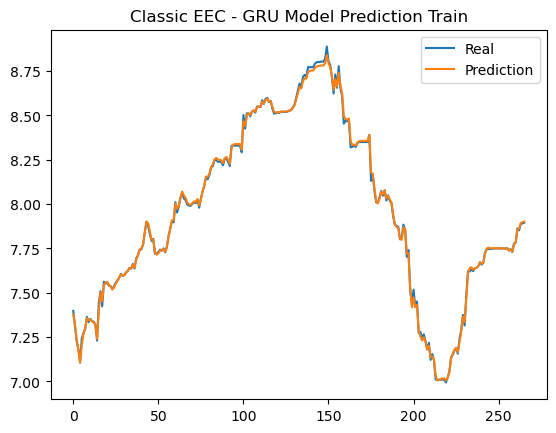

In [53]:
data_type = "train"
y_pred_train, y = GRU.predict(data=data_type)
y_pred_train, y = minmax_scaler.inverse_transform(y_pred_train.reshape(-1,1)), minmax_scaler.inverse_transform(y.reshape(-1,1))

plt.figure()
plt.title("Classic EEC - GRU Model Prediction Train")
plt.plot(y, label="Real")
plt.plot(y_pred_train, label="Prediction")
plt.legend()
plt.show()

#### LSTM

In [54]:
# Initializing the LSTM class

LSTM = long_short_term_memory.LSTM(classic_development_df["Normalized Spot"], train_test_ratio=0.8)

##### Tuning Training Parameters

In [55]:
train_param_grid = {
    "l2" : [1e-02, 1e-03, 1e-04, 1e-05, 1e-06],
    "lrs" : [1, 0.1, 0.01, 0.001],
    "epochs" : [20, 30, 40, 60, 80, 100, 120, 140, 150, 160],
    "epochs_mid" : 80,
    "patience": 10,
    "min_delta": 1e-4,
    "n_splits": 5,
    "val_size": 200,
    "min_train_size" : 50     
}

model_param = {
    "lookback": 40,
    "hidden_size": 16,
    "num_layers": 1,
}

LSTM_training_params = LSTM.tune_train(train_param_grid, model_param)

LSTM.training_params

Training results: cv_mse : 0.07625691592693329, val_size : 200, n_splits : 5


{'lr': 0.1, 'l2': 0.001, 'epochs': 160}

##### Tuning Model Parameters

In [56]:
model_param_grid = {
    "lookback": [int(x) for x in np.linspace(10, 70, 6)],
    "hidden_size": [2, 4, 8, 16],
    "num_layers": [1, 2],
}
LSTM.tune_model(model_param_grid)

lookback=10, hidden=2, layers=1 → MSE=0.000176
lookback=10, hidden=2, layers=2 → MSE=0.000541
lookback=10, hidden=4, layers=1 → MSE=0.000235
lookback=10, hidden=4, layers=2 → MSE=0.000288
lookback=10, hidden=8, layers=1 → MSE=0.000205
lookback=10, hidden=8, layers=2 → MSE=0.002104
lookback=10, hidden=16, layers=1 → MSE=0.000444
lookback=10, hidden=16, layers=2 → MSE=0.001127
lookback=22, hidden=2, layers=1 → MSE=0.000183
lookback=22, hidden=2, layers=2 → MSE=0.000249
lookback=22, hidden=4, layers=1 → MSE=0.000192
lookback=22, hidden=4, layers=2 → MSE=0.000690
lookback=22, hidden=8, layers=1 → MSE=0.000261
lookback=22, hidden=8, layers=2 → MSE=0.000398
lookback=22, hidden=16, layers=1 → MSE=0.000434
lookback=22, hidden=16, layers=2 → MSE=0.002865
lookback=34, hidden=2, layers=1 → MSE=0.000210
lookback=34, hidden=2, layers=2 → MSE=0.000777
lookback=34, hidden=4, layers=1 → MSE=0.000183
lookback=34, hidden=4, layers=2 → MSE=0.000359
lookback=34, hidden=8, layers=1 → MSE=0.000239
lookback=

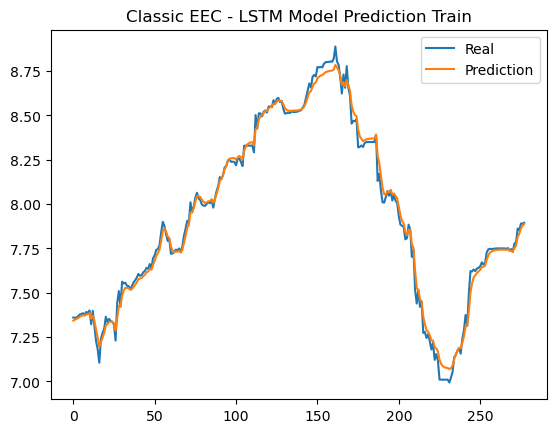

In [57]:
data_type = "train"
y_pre_train, y = LSTM.predict(data=data_type)
y_pre_train, y = minmax_scaler.inverse_transform(y_pre_train.reshape(-1,1)), minmax_scaler.inverse_transform(y.reshape(-1,1))

plt.figure()
plt.title("Classic EEC - LSTM Model Prediction Train")
plt.plot(y, label="Real")
plt.plot(y_pre_train, label="Prediction")
plt.legend()
plt.show()

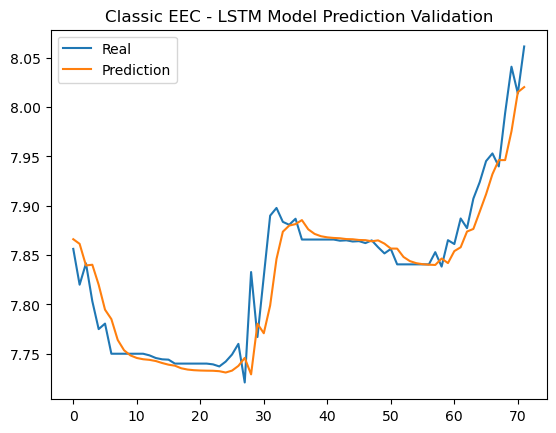

In [58]:
data_type = "validation"
y_pre_validation, y = LSTM.predict(data=data_type)
y_pre_validation, y = minmax_scaler.inverse_transform(y_pre_validation.reshape(-1,1)), minmax_scaler.inverse_transform(y.reshape(-1,1))

plt.figure()
plt.title("Classic EEC - LSTM Model Prediction Validation")
plt.plot(y, label="Real")
plt.plot(y_pre_validation, label="Prediction")
plt.legend()
plt.show()

### Forecast

We will go through the classic_test_df which is data that has never been seen by our model. We will :
* Iterate through every week, each 5 business days actually
* Calibrate the model parameters
* Try to forecast the price of the following week

In [59]:
# # Walk-forward weekly forecasting on the unseen test set
# # - ARIMA (on Delta → integrated back to SPOT)
# # - GRU (on Normalized Spot → inverse-scaled to SPOT)
# # - LSTM (on Normalized Spot → inverse-scaled to SPOT)

# arma_weekly_preds = pd.Series(index=classic_test_df.index, dtype=float)
# gru_weekly_preds  = pd.Series(index=classic_test_df.index, dtype=float)
# lstm_weekly_preds = pd.Series(index=classic_test_df.index, dtype=float)

# # We will always re-fit on all data seen up to the *start* of each week,
# # then forecast the *next* 5 business days (if available).
# week_size = 5

# for wk_start in range(0, len(classic_test_df), week_size):
#     print(f"\n\nWeek {(wk_start + 1)/week_size}/{len(classic_test_df)/week_size}\n\n")

#     wk_end = wk_start + week_size
#     next_wk_end = wk_end + week_size

#     # If we don't have a full “next week” to forecast, stop here.
#     if next_wk_end > len(classic_test_df):
#         break

#     # Data seen so far (development + already observed test weeks)
#     seen_df = pd.concat(
#         [classic_development_df, classic_test_df.iloc[:wk_end]],
#         axis=0
#     )

#     # The *next* week to forecast (targets we will compare with later)
#     next_week_idx = classic_test_df.iloc[wk_end:next_wk_end].index

#     # -------------------------
#     # ARMA / ARIMA on Delta
#     # -------------------------
#     # Calibrate max AR/MA orders, select best model (AICc + Ljung-Box), then forecast next 5 deltas
#     arma_model = linear_time_series.LinearTimeSeriesModel(seen_df["Delta"])
#     arma_model.get_ma_max_order()
#     arma_model.get_ar_max_order()
#     arma_model.select_model()  # picks ARIMA(p,0,q) with diagnostic check and best AICc
#     # Forecast 5 steps ahead beyond the end of the seen series (out-of-sample)
#     start = len(arma_model.dependent_time_series)
#     end   = start + week_size - 1
#     delta_forecast = arma_model.model_prediction(start_index=start, end_index=end)  # 5-step Δ forecast  :contentReference[oaicite:0]{index=0}

#     # Convert Δ → SPOT by integrating from the last known SPOT level
#     last_spot_level = seen_df["SPOT"].iloc[-1]
#     arma_spot_week = last_spot_level + np.cumsum(np.array(delta_forecast, dtype=float))
#     arma_weekly_preds.loc[next_week_idx] = arma_spot_week

    
#     # GRU on Normalized Spot

#     # Re-initialize on all seen normalized data, tune, and forecast 5 steps
#     gru_model = gated_reccurent_unit.GRU(seen_df["Normalized Spot"], train_test_ratio=0.8)

#     gru_model.tune_train(train_param_grid, model_param)
#     gru_model.tune_model(model_param_grid)  # sets gru_model.model_params and trains final model  :contentReference[oaicite:1]{index=1}
#     gru_norm_forecast = gru_model.predict_future(days=week_size)  # normalized units  :contentReference[oaicite:2]{index=2}
#     gru_spot_week = minmax_scaler.inverse_transform(gru_norm_forecast.reshape(-1, 1)).ravel()
#     gru_weekly_preds.loc[next_week_idx] = gru_spot_week

#     # LSTM on Normalized Spot
#     # -------------------------
#     lstm_model = long_short_term_memory.LSTM(seen_df["Normalized Spot"], train_test_ratio=0.8)

#     lstm_model.tune_train(train_param_grid, model_param)
#     lstm_model.tune_model(model_param_grid)  # sets lstm_model.model_params and trains final model  :contentReference[oaicite:3]{index=3}
#     lstm_norm_forecast = lstm_model.predict_future(days=week_size)  # normalized units  :contentReference[oaicite:4]{index=4}
#     lstm_spot_week = minmax_scaler.inverse_transform(lstm_norm_forecast.reshape(-1, 1)).ravel()
#     lstm_weekly_preds.loc[next_week_idx] = lstm_spot_week

# # -------------------------
# # Collect results and (optionally) visualize
# # -------------------------
# weekly_forecasts = pd.DataFrame({
#     "ARIMA_SPOT": arma_weekly_preds,
#     "GRU_SPOT":   gru_weekly_preds,
#     "LSTM_SPOT":  lstm_weekly_preds,
#     "REAL_SPOT":  classic_test_df["SPOT"]
# }).dropna(how="all")

# display(weekly_forecasts.head(15))

# weekly_forecasts.to_csv("weekly_forecast.csv")

In [60]:
weekly_forecasts = pd.read_csv("weekly_forecast.csv", index_col=0)
weekly_forecasts.dropna(how="any", inplace=True)
weekly_forecasts

,ARIMA_SPOT,GRU_SPOT,LSTM_SPOT,REAL_SPOT
366,8.276770,8.283732,8.035337,8.292878
367,8.278923,8.294793,8.031907,8.232345
368,8.281077,8.305668,8.030201,8.470269
369,8.283232,8.316322,8.029502,8.356326
370,8.285386,8.326722,8.029219,8.500000
...,...,...,...,...
446,7.972371,7.983124,7.975964,7.969759
447,7.974742,7.988333,7.984163,7.969839
448,7.977113,7.996177,7.994092,7.986663
449,7.979484,8.004579,8.005639,7.988577


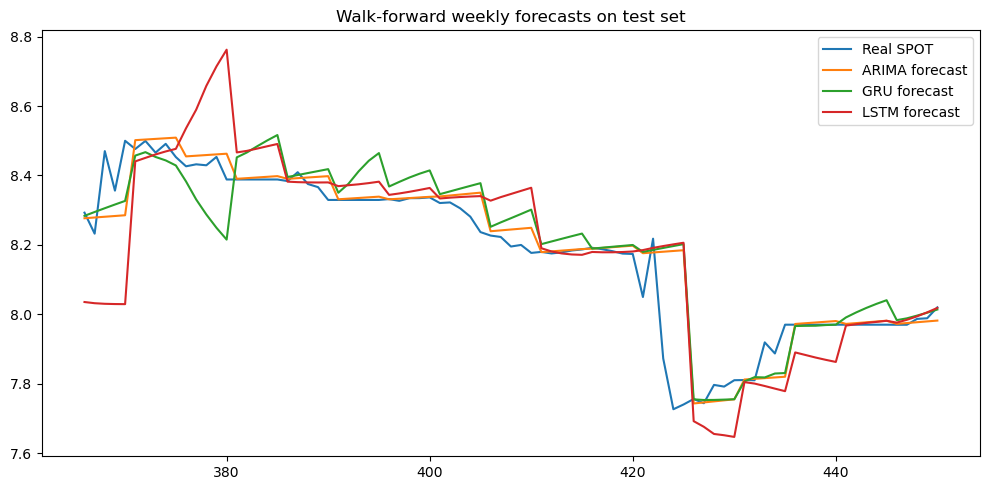

In [61]:
plt.figure(figsize=(10, 5))
plt.title("Walk-forward weekly forecasts on test set")
plt.plot(weekly_forecasts.index, weekly_forecasts["REAL_SPOT"], label="Real SPOT")
plt.plot(weekly_forecasts.index, weekly_forecasts["ARIMA_SPOT"], label="ARIMA forecast")
plt.plot(weekly_forecasts.index, weekly_forecasts["GRU_SPOT"], label="GRU forecast")
plt.plot(weekly_forecasts.index, weekly_forecasts["LSTM_SPOT"], label="LSTM forecast")
plt.legend()
plt.tight_layout()
plt.show()

In [64]:
mse = {}

mse["ARIMA"] = float(np.mean((weekly_forecasts["REAL_SPOT"]- weekly_forecasts["ARIMA_SPOT"])**2))
mse["GRU"] = float(np.mean((weekly_forecasts["REAL_SPOT"]- weekly_forecasts["GRU_SPOT"])**2))
mse["LSTM"] = float(np.mean((weekly_forecasts["REAL_SPOT"]- weekly_forecasts["LSTM_SPOT"])**2))

mse

{'ARIMA': 0.008306651497464701,
 'GRU': 0.011420774413932805,
 'LSTM': 0.021880533936845893}